In [ ]:
from chase.base import *
from chase.utils import *
from chase.fit import *
from mypy.explib.frey2014 import frey2014
from mypy.explib.
pd.set_option('display.max_colwidth', 100)

# Proportion sampling each option

In [43]:
p_sample_H = {}

In [18]:
def sample_proportion(data):
    arr = []
    for i, grp in data.groupby(['subject', 'problem']):
        p_sample_H = np.mean(1*(grp.option==1).values)
        arr.append([grp.subject.values[0], grp.problem.values[0], p_sample_H])
    df = pd.DataFrame(arr, columns=['subject', 'problem', 'p_sample_H'])
    return df

In [124]:
data = pd.read_csv('data/hertwig2004/hertwig2004_trialdata.csv', index_col=0)
df = sample_proportion(data)
p_sample_H['hertwig2004'] = df.groupby('subject').agg(np.mean).reset_index()['p_sample_H']

In [49]:
from mypy.explib.hau2008 import hau2008
sdata = hau2008.sampledata_by_subject(study=1)
arr = []
for sd in sdata:
    arr.append(np.mean([np.mean(trial['sampled_option']) for trial in sdata[sd]]))
p_sample_H['hau2008exp1'] = np.array(arr)

sdata = hau2008.sampledata_by_subject(study=2)
arr = []
for sd in sdata:
    arr.append(np.mean([np.mean(trial['sampled_option']) for trial in sdata[sd]]))
p_sample_H['hau2008exp2'] = np.array(arr)

In [61]:
from mypy.explib.technion import technion
technion.load_data('est')

In [86]:
data = technion.df[['ID', 'Problem', 'Trial', 'sampledH', 'sampout', 'choseH']]
data.columns = ['subject', 'problem', 'trial', 'option', 'outcome', 'choice']
df = sample_proportion(data)
p_sample_H['tpt'] = df.groupby('subject').agg(np.mean).reset_index()['p_sample_H']

In [121]:
data = pd.read_csv('/Users/markant/code/ChaseExp/markant_trialdata.csv', index_col=0)

In [98]:
df = sample_proportion(data)
p_sample_H['markant'] = df.groupby('subject').agg(np.mean).reset_index()['p_sample_H']

In [101]:
from mypy.explib.frey2014 import frey2014

/Users/markant/code/py/mypy/explib/frey2014/frey2014.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  gambles_srt = gambles.sort(['domain', 'pairtype', 'session'])


In [118]:
freydata = frey2014.load_data()
data = freydata[['partid', 'gamble_lab', 'sample_ind', 'sample_opt', 'sample_out', 'decision']]
data.columns = ['subject', 'problem', 'trial', 'option', 'outcome', 'choice']
data['option'] = 1*(data['option'].values=='H')
data['choice'] = 1*(data['choice'].values=='H')
df = sample_proportion(data)
p_sample_H['frey2015'] = df.groupby('subject').agg(np.mean).reset_index()['p_sample_H']

/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [119]:
for exp in ['hertwig2004', 'hau2008exp1', 'hau2008exp2', 'tpt', 'frey2015', 'markant']:
    print exp, np.round(p_sample_H[exp].mean(), 3), np.round(p_sample_H[exp].std(), 3)

hertwig2004 0.491 0.065
hau2008exp1 0.499 0.058
hau2008exp2 0.512 0.058
tpt 0.491 0.021
frey2015 0.5 0.024
markant 0.51 0.044


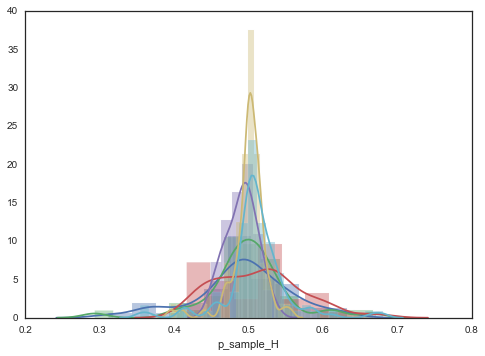

In [120]:
for exp in ['hertwig2004', 'hau2008exp1', 'hau2008exp2', 'tpt', 'frey2015', 'markant']:
    sns.distplot(p_sample_H[exp])

In [89]:
from scipy.stats import ttest_1samp

In [100]:
for exp in ['hertwig2004', 'hau2008exp1', 'hau2008exp2', 'tpt', 'markant']:
    print ttest_1samp(p_sample_H[exp], .5)

Ttest_1sampResult(statistic=-0.98136578442044642, pvalue=0.33123322010484113)
Ttest_1sampResult(statistic=-0.093196680789769573, pvalue=0.92620124509927093)
Ttest_1sampResult(statistic=1.3137500286299362, pvalue=0.19680692665750951)
Ttest_1sampResult(statistic=-2.7891557470383481, pvalue=0.0082133306539135201)
Ttest_1sampResult(statistic=2.3520638709009583, pvalue=0.020649143715543307)


# Switching

In [2]:
data = pd.read_csv('data/frey_data.csv', index_col=0)
problems = {gid: frey2014.get_options(gid) for gid in data.problem.unique()}
data.head(10)

,subject,problem,group,choice,samplesize
0,1,S1G1,0,0,12
1,1,S2G1,0,1,10
2,1,S3G1,0,0,10
3,1,S4G1,0,0,10
4,1,S5G1,0,0,10
5,1,S6G1,0,1,10
6,1,S7G1,0,0,10
7,1,S8G1,0,0,12
8,1,S9G1,0,0,10
9,1,S10G1,0,0,10


In [24]:
arr = []
for p_switch in np.arange(.1, 1, .1):
    print p_switch
    pars = {'theta': 5,
            'firstoption': None,
            'p_switch': p_switch}

    m = CHASEOptionalStoppingSwitchingModel(drift='cpt',
                                            startdist='laplace')
    
    for pid in problems:
        
        res = m(problems[pid], pars)
        cp = res['p_resp'][1]
        ss = np.dot(res['p_resp'], res['exp_samplesize'])        
        arr.append([p_switch, pid, cp, ss])

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [25]:
df = pd.DataFrame(arr, columns=['p_switch', 'pid', 'pH', 'ss'])

In [26]:
aggdf = df.groupby('p_switch').agg(np.mean).reset_index()

In [27]:
aggdf

,p_switch,pH,ss
0,0.1,0.536616,13.101111
1,0.2,0.545747,15.141137
2,0.3,0.550499,16.733981
3,0.4,0.553290,18.003373
4,0.5,0.555004,19.040502
5,0.6,0.556071,19.909198
6,0.7,0.556729,20.655904
7,0.8,0.557120,21.317677
8,0.9,0.557334,21.931809
